In [61]:
import numpy as np
import pandas as pd
import matplotlib as plt
import missingno as msno
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import ipywidgets as widgets
from IPython.display import display
from scipy.sparse import coo_matrix
import ast


In [62]:
titles = pd.read_csv("archive/titles.csv")
credits = pd.read_csv("archive/credits.csv")

In [63]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_id,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,['documentation'],['US'],1.0,NaN,NaN,NaN,0.600,NaN
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],NaN,tt0075314,8.2,808582.0,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],NaN,tt0068473,7.7,107673.0,10.010,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],NaN,tt0071853,8.2,534486.0,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,NaN,150,"['war', 'action']","['GB', 'US']",NaN,tt0061578,7.7,72662.0,20.398,7.600


In [64]:
titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5850 entries, 0 to 5849
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    5850 non-null   object 
 1   title                 5849 non-null   object 
 2   type                  5850 non-null   object 
 3   description           5832 non-null   object 
 4   release_year          5850 non-null   int64  
 5   age_certification     3231 non-null   object 
 6   runtime               5850 non-null   int64  
 7   genres                5850 non-null   object 
 8   production_countries  5850 non-null   object 
 9   seasons               2106 non-null   float64
 10  imdb_id               5447 non-null   object 
 11  imdb_score            5368 non-null   float64
 12  imdb_votes            5352 non-null   float64
 13  tmdb_popularity       5759 non-null   float64
 14  tmdb_score            5539 non-null   float64
dtypes: float64(5), int64(

<Axes: xlabel='release_year'>

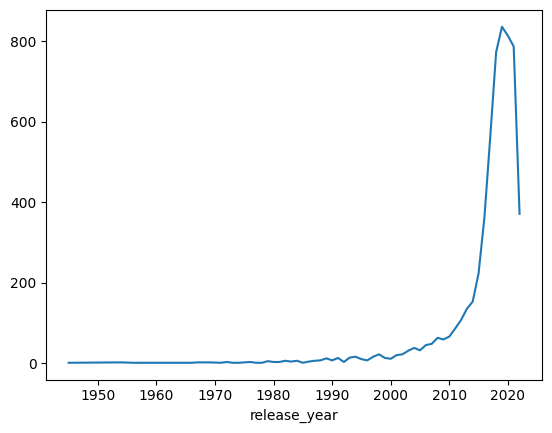

In [65]:
groups = titles.groupby(['release_year'])['release_year'].count()
groups.plot(kind='line')


In [66]:
titles = titles.drop(columns = ['imdb_id'])
titles['seasons'] = titles['seasons'].fillna(1.0)

<Axes: >

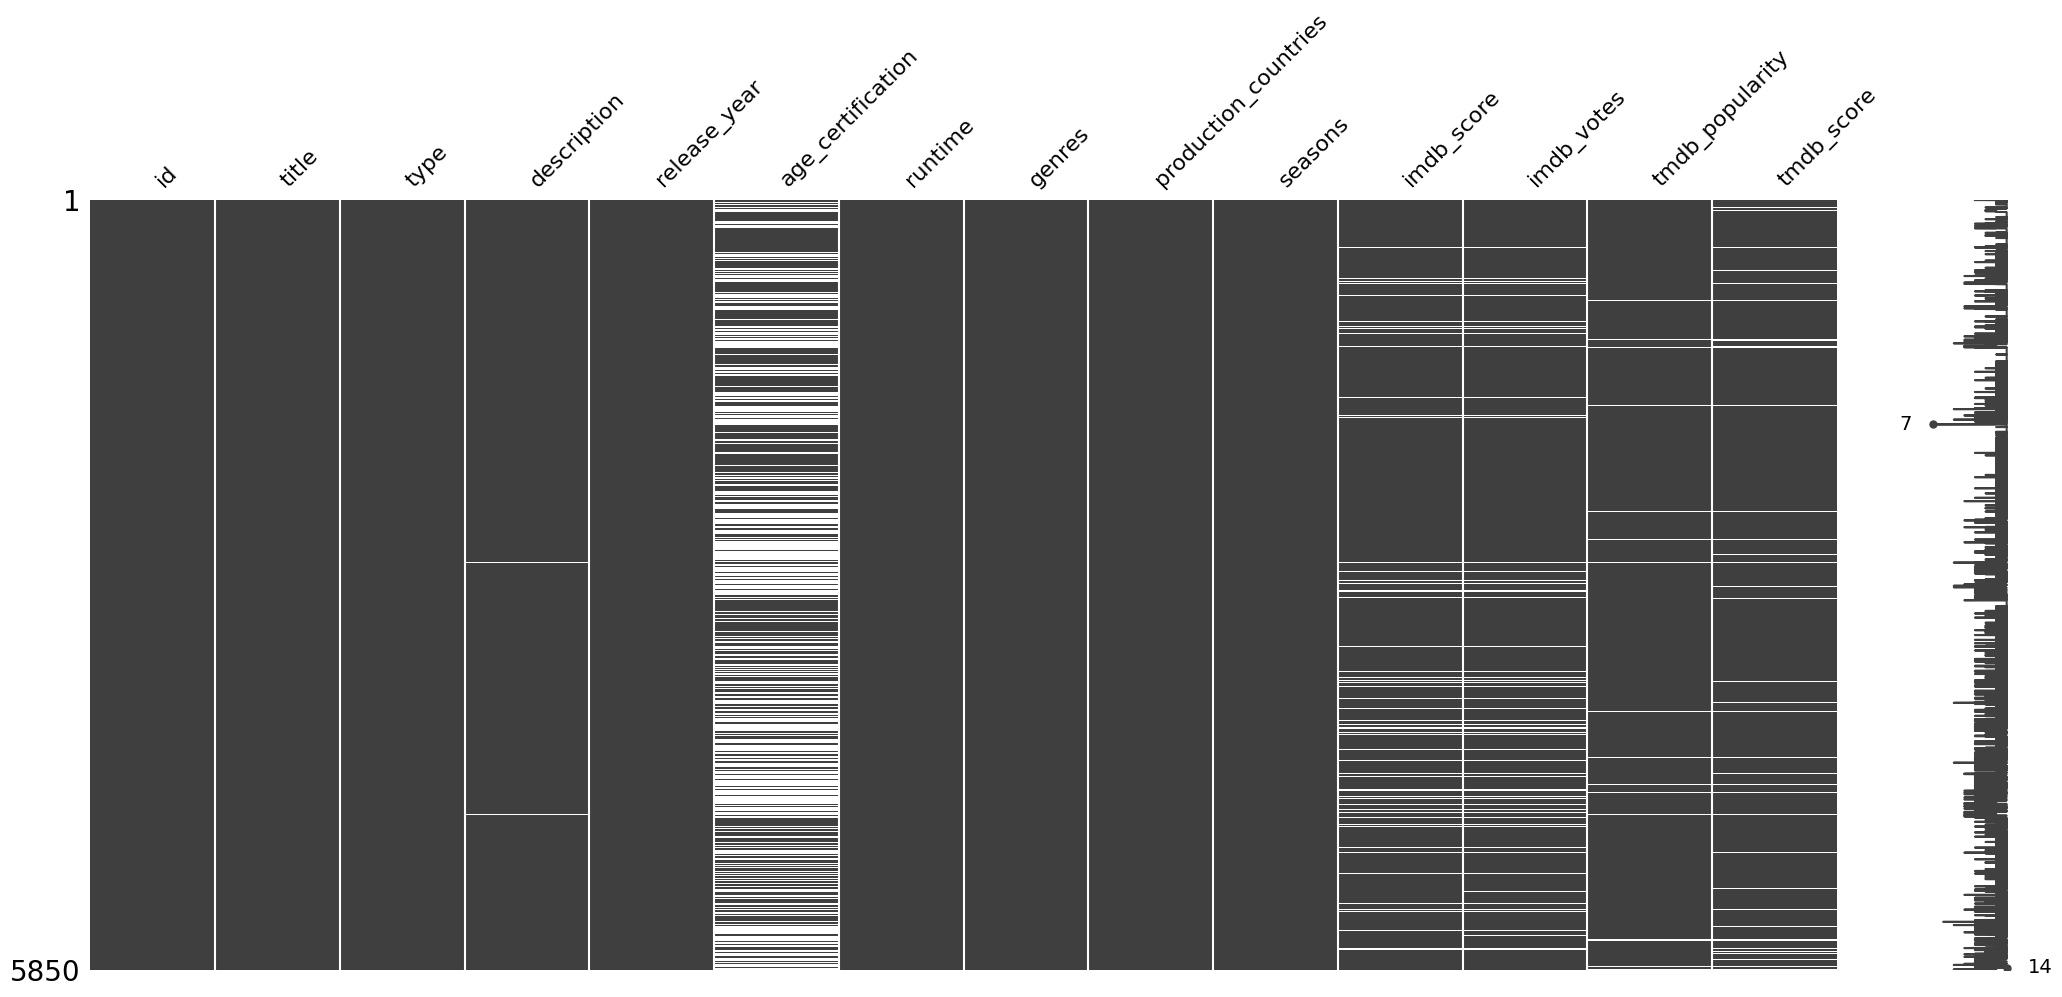

In [67]:
msno.matrix(titles)

In [68]:
list(titles['age_certification'].unique())

['TV-MA',
 'R',
 'PG',
 nan,
 'TV-14',
 'PG-13',
 'TV-PG',
 'TV-Y',
 'TV-G',
 'TV-Y7',
 'G',
 'NC-17']

In [69]:
Counter(list(titles['age_certification']))

Counter({'TV-MA': 883,
         'R': 556,
         'PG': 233,
         nan: 2619,
         'TV-14': 474,
         'PG-13': 451,
         'TV-PG': 188,
         'TV-Y': 107,
         'TV-G': 79,
         'TV-Y7': 120,
         'G': 124,
         'NC-17': 16})

In [70]:
# merge NC-17, R, TV-MA => Adult
# merge  'PG', 'TV-14','PG-13','TV-PG' => Teen
# merge  'G', 'TV-G, TV-Y, TV-MA, 'TV-Y7' => Children

replacement = {'NC-17': 'R', 'TV-MA': 'R', 'TV-14': 'PG','PG-13':'PG','TV-PG':'PG', 'TV-G':'G', 'TV-Y':'G', 'TV-MA':'G', 'TV-Y7':'G'}
titles['age_certification'] = titles['age_certification'].replace(replacement) 

In [71]:
value_counts = titles['age_certification'].value_counts()
total_non_nan = titles['age_certification'].count()
nan_count = titles['age_certification'].isna().sum()

In [72]:
nan_to_fill = {}
for value, count in value_counts.items():
    nan_to_fill[value]  = int(round(count / total_non_nan * nan_count))

In [73]:
for value, count in nan_to_fill.items():
    titles['age_certification'].fillna(value, limit=count, inplace=True)

In [74]:
print(len(nan_to_fill), nan_count)

3 2619


In [75]:
mean_value_imdb_score = titles['imdb_score'].mean()
titles['imdb_score'].fillna(mean_value_imdb_score, inplace=True)

mean_value_imdb_votes = titles['imdb_votes'].mean()
titles['imdb_votes'].fillna(mean_value_imdb_votes, inplace=True)

mean_value_tmdb_popularity = titles['tmdb_popularity'].mean()
titles['tmdb_popularity'].fillna(mean_value_tmdb_popularity, inplace=True)

mean_value_tmdb_score = titles['tmdb_score'].mean()
titles['tmdb_score'].fillna(mean_value_tmdb_score, inplace=True)

<Axes: >

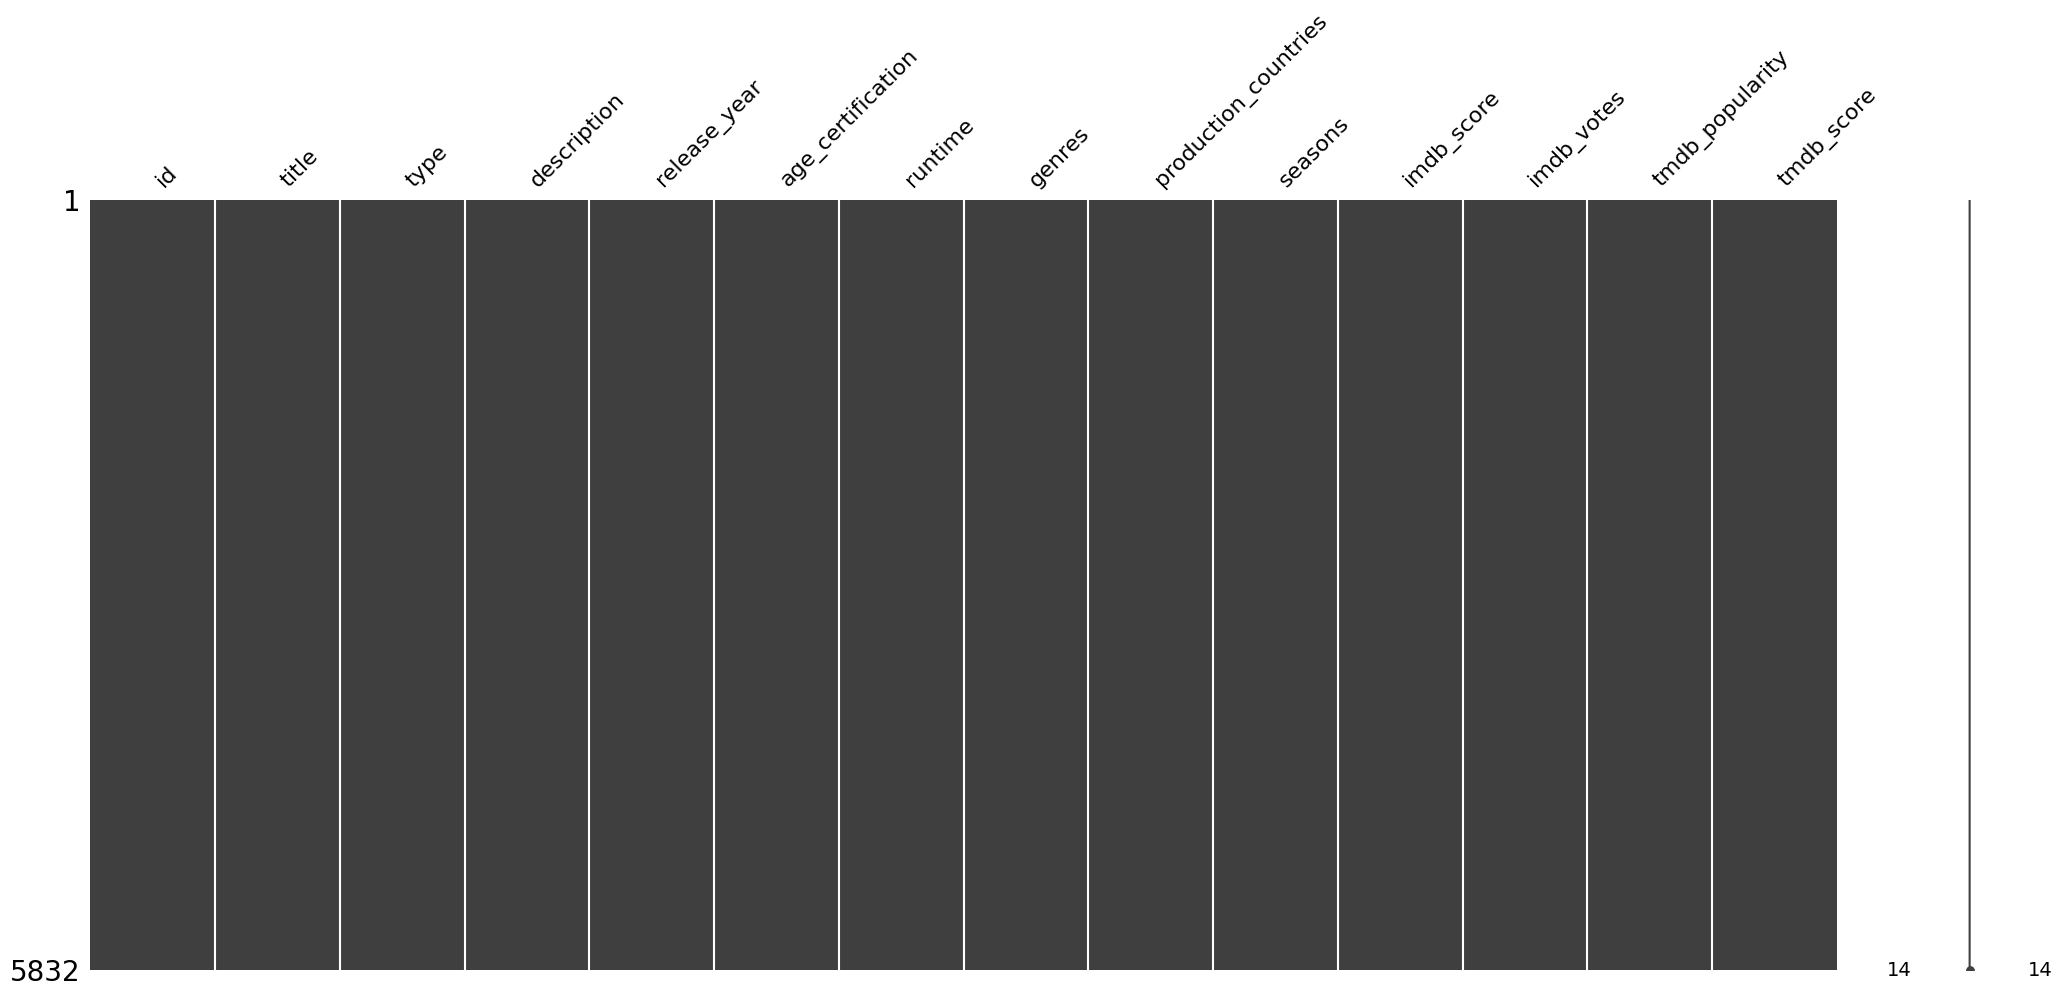

In [76]:
titles.dropna(inplace=True)
msno.matrix(titles)

In [77]:
titles.head()

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,G,51,['documentation'],['US'],1.0,6.510861,23439.382474,0.600,6.829175
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],1.0,8.200000,808582.000000,40.965,8.179000
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,"['drama', 'action', 'thriller', 'european']",['US'],1.0,7.700000,107673.000000,10.010,7.300000
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,"['fantasy', 'action', 'comedy']",['GB'],1.0,8.200000,534486.000000,15.461,7.811000
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,PG,150,"['war', 'action']","['GB', 'US']",1.0,7.700000,72662.000000,20.398,7.600000


In [78]:
def clean_title(text):
    return re.sub("[^a-zA-Z0-9 ]","",text)

In [79]:
titles["title"] = titles["title"].apply(clean_title)

In [80]:
vctorizer = TfidfVectorizer(ngram_range=(1,4))
tfidf = vctorizer.fit_transform(titles['title'])

In [81]:
def search(title):
    title = clean_title(title)
    q = vctorizer.transform([title])
    sim = cosine_similarity(q,tfidf).flatten()
    indices = np.argpartition(sim,-5)[-5:]
    res = titles.iloc[indices][::-1]
    return res


In [82]:
search("Taxi")

,id,title,type,description,release_year,age_certification,runtime,genres,production_countries,seasons,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,"['drama', 'crime']",['US'],1.0,8.200000,808582.000000,40.965,8.179000
1380,tm248010,Taxi Driver,MOVIE,A small-town mechanic turned chauffeur for the...,2015,PG,100,"['comedy', 'crime', 'drama']",['NG'],1.0,6.000000,69.000000,1.191,5.300000
822,tm946846,Taxi Ballad,MOVIE,A taxi driver new to Beirut forms an unlikely ...,2012,PG,93,['drama'],"['US', 'LB', 'AE']",1.0,6.510861,23439.382474,0.600,6.829175
477,tm33729,Taxi No 9 2 11,MOVIE,A cabbie and businessman both in need of big m...,2006,PG,116,"['drama', 'thriller', 'comedy']",['IN'],1.0,7.200000,9964.000000,2.636,6.500000
1922,tm244175,The Zookeepers Wife,MOVIE,"The account of keepers of the Warsaw Zoo, Jan ...",2017,PG,126,"['war', 'drama', 'history']","['CZ', 'GB', 'US']",1.0,7.000000,43091.000000,23.231,7.400000


In [83]:
titles.isna().sum()

id                      0
title                   0
type                    0
description             0
release_year            0
age_certification       0
runtime                 0
genres                  0
production_countries    0
seasons                 0
imdb_score              0
imdb_votes              0
tmdb_popularity         0
tmdb_score              0
dtype: int64

In [84]:
titles['genres'] = titles['genres'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else [])


In [85]:
type(titles['genres'][0])

list

In [86]:
titles = titles.drop(['description', 'runtime', 'production_countries', 'seasons', 'type'], axis = 1)

In [87]:
title_genres = titles.copy()

x = []
for index, row in titles.iterrows():
    x.append(index)
    for genre in row['genres']:
        title_genres.at[index, genre] = 1
        
title_genres.head(3)


,id,title,release_year,age_certification,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,documentation,...,romance,western,history,music,family,horror,scifi,animation,reality,sport
0,ts300399,Five Came Back The Reference Films,1945,G,[documentation],6.510861,23439.382474,0.600,6.829175,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,tm84618,Taxi Driver,1976,R,"[drama, crime]",8.200000,808582.000000,40.965,8.179000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,tm154986,Deliverance,1972,R,"[drama, action, thriller, european]",7.700000,107673.000000,10.010,7.300000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
title_genres = title_genres.fillna(0)
title_genres.head(3)

,id,title,release_year,age_certification,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,documentation,...,romance,western,history,music,family,horror,scifi,animation,reality,sport
0,ts300399,Five Came Back The Reference Films,1945,G,[documentation],6.510861,23439.382474,0.600,6.829175,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,tm84618,Taxi Driver,1976,R,"[drama, crime]",8.200000,808582.000000,40.965,8.179000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tm154986,Deliverance,1972,R,"[drama, action, thriller, european]",7.700000,107673.000000,10.010,7.300000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Contect basef recomendation

In [95]:
user_1_movies = [
    {'title':"The Return of the Prodigal Son", 'ratings':5.0},
    {'title':"White Christmas", 'ratings':3.5},
    {'title':"Dark Waters", 'ratings':2.3},
    {'title':"Grey's Anatomy", 'ratings':4.1},
    {'title':"Inception", 'ratings':4.7},
    {'title':"Halloween", 'ratings':3.2},
    {'title':"Tears of the Sun", 'ratings':2.5},
    {'title':"Catch and Release", 'ratings':4.7},
    {'title':"Jodhaa Akbar", 'ratings':5.0}
]

user_1_movies = pd.DataFrame(user_1_movies)
user_1_movies

,title,ratings
0,The Return of the Prodigal Son,5.0
1,White Christmas,3.5
2,Dark Waters,2.3
3,Grey's Anatomy,4.1
4,Inception,4.7
5,Halloween,3.2
6,Tears of the Sun,2.5
7,Catch and Release,4.7
8,Jodhaa Akbar,5.0


In [96]:
user_movie_Id = titles[titles['title'].isin(user_1_movies['title'])]
user_1_movies = pd.merge(user_movie_Id, user_1_movies)
user_1_movies


,id,title,release_year,age_certification,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,ratings
0,tm16479,White Christmas,1954,PG,"[romance, comedy]",7.5,42488.0,8.915,7.200,3.5
1,tm204541,Dark Waters,1956,PG,"[action, drama, romance, thriller]",6.7,610.0,0.849,5.900,2.3
2,tm90896,The Return of the Prodigal Son,1976,PG,"[music, drama, crime]",7.2,780.0,1.858,5.300,5.0
3,tm92641,Inception,2010,PG,"[action, scifi, music, thriller]",8.8,2294231.0,108.284,8.400,4.7
4,tm79895,Halloween,2007,R,[horror],6.0,119606.0,38.491,6.200,3.2
5,tm137342,Tears of the Sun,2003,R,"[war, action, drama, thriller]",6.6,121957.0,43.254,6.797,2.5
6,tm39487,Catch and Release,2006,PG,"[drama, romance, comedy]",5.9,26528.0,9.435,5.900,4.7
7,tm29269,Jodhaa Akbar,2008,PG,"[romance, history, war, action, drama]",7.5,32440.0,11.959,7.400,5.0


In [97]:
user_1_movies = user_1_movies.drop(['genres','release_year','age_certification'], axis=1)

In [98]:
user_1_movies.head()

,id,title,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,ratings
0,tm16479,White Christmas,7.5,42488.0,8.915,7.2,3.5
1,tm204541,Dark Waters,6.7,610.0,0.849,5.9,2.3
2,tm90896,The Return of the Prodigal Son,7.2,780.0,1.858,5.3,5.0
3,tm92641,Inception,8.8,2294231.0,108.284,8.4,4.7
4,tm79895,Halloween,6.0,119606.0,38.491,6.2,3.2


In [99]:
user_1_movies_g = title_genres[title_genres.id.isin(user_1_movies.id)]
user_1_movies_g

,id,title,release_year,age_certification,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,documentation,...,romance,western,history,music,family,horror,scifi,animation,reality,sport
13,tm16479,White Christmas,1954,PG,"[romance, comedy]",7.5,42488.0,8.915,7.200,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,tm204541,Dark Waters,1956,PG,"[action, drama, romance, thriller]",6.7,610.0,0.849,5.900,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,tm90896,The Return of the Prodigal Son,1976,PG,"[music, drama, crime]",7.2,780.0,1.858,5.300,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
237,tm92641,Inception,2010,PG,"[action, scifi, music, thriller]",8.8,2294231.0,108.284,8.400,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
289,tm79895,Halloween,2007,R,[horror],6.0,119606.0,38.491,6.200,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
322,tm137342,Tears of the Sun,2003,R,"[war, action, drama, thriller]",6.6,121957.0,43.254,6.797,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
345,tm39487,Catch and Release,2006,PG,"[drama, romance, comedy]",5.9,26528.0,9.435,5.900,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
412,tm29269,Jodhaa Akbar,2008,PG,"[romance, history, war, action, drama]",7.5,32440.0,11.959,7.400,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
user_1_movies_g.reset_index(drop=True, inplace=True)
user_1_movies_g.drop(['id','title','genres','release_year','age_certification', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score'], axis=1, inplace=True)
user_1_movies_g

/var/folders/1h/8zf2rcls4h37bpx4_bc7brjc0000gn/T/ipykernel_24268/506939612.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_1_movies_g.drop(['id','title','genres','release_year','age_certification', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score'], axis=1, inplace=True)


,documentation,drama,crime,action,thriller,european,fantasy,comedy,war,romance,western,history,music,family,horror,scifi,animation,reality,sport
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
user_1_movies_g.head(3)

,documentation,drama,crime,action,thriller,european,fantasy,comedy,war,romance,western,history,music,family,horror,scifi,animation,reality,sport
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
print('Shape of Lawrence_movie_ratings is:',user_1_movies.shape)
print('Shape of Lawrence_genres_df is:',user_1_movies_g.shape)

Shape of Lawrence_movie_ratings is: (8, 7)
Shape of Lawrence_genres_df is: (8, 19)


In [103]:
user_profile = user_1_movies_g.T.dot(user_1_movies.ratings)
user_profile

documentation     0.0
drama            19.5
crime             5.0
action           14.5
thriller          9.5
european          0.0
fantasy           0.0
comedy            8.2
war               7.5
romance          15.5
western           0.0
history           5.0
music             9.7
family            0.0
horror            3.2
scifi             4.7
animation         0.0
reality           0.0
sport             0.0
dtype: float64

In [104]:
title_genres = title_genres.set_index(title_genres.id)
title_genres.head()

,id,title,release_year,age_certification,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,documentation,...,romance,western,history,music,family,horror,scifi,animation,reality,sport
id,,,,,,,,,,,,,,,,,,,,,
ts300399,ts300399,Five Came Back The Reference Films,1945,G,[documentation],6.510861,23439.382474,0.600,6.829175,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tm84618,tm84618,Taxi Driver,1976,R,"[drama, crime]",8.200000,808582.000000,40.965,8.179000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tm154986,tm154986,Deliverance,1972,R,"[drama, action, thriller, european]",7.700000,107673.000000,10.010,7.300000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tm127384,tm127384,Monty Python and the Holy Grail,1975,PG,"[fantasy, action, comedy]",8.200000,534486.000000,15.461,7.811000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tm120801,tm120801,The Dirty Dozen,1967,PG,"[war, action]",7.700000,72662.000000,20.398,7.600000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [109]:
title_genres.drop(columns=['id','title','release_year', 'age_certification', 'genres', 'imdb_score', 'imdb_votes', 'tmdb_popularity', 'tmdb_score'], axis = 1, inplace=True)


In [110]:
title_genres.head()


,documentation,drama,crime,action,thriller,european,fantasy,comedy,war,romance,western,history,music,family,horror,scifi,animation,reality,sport
id,,,,,,,,,,,,,,,,,,,
ts300399,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tm84618,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tm154986,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tm127384,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tm120801,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
recommendation_table_df = title_genres.dot(user_profile) /  user_profile.sum()
recommendation_table_df.head()

id
ts300399    0.000000
tm84618     0.239492
tm154986    0.425220
tm127384    0.221896
tm120801    0.215054
dtype: float64

In [125]:
recommendation_table_df.sort_values(ascending=False, inplace=True)
recommendation_table_df.head(20)

id
ts80519     0.797654
tm164557    0.705767
tm322243    0.705767
ts252166    0.705767
ts83359     0.705767
ts312082    0.702835
ts75620     0.702835
ts20429     0.702835
ts215683    0.688172
ts10206     0.658847
ts21695     0.656891
tm88366     0.656891
tm73058     0.656891
tm852360    0.656891
ts25765     0.653959
ts41883     0.650049
tm852172    0.641251
ts187541    0.641251
ts20791     0.641251
ts21740     0.631476
dtype: float64

In [130]:
# first we make a copy of the original movies_df
copy = titles.copy(deep=True)

# Then we set its index to movieId
copy = copy.set_index('id', drop=True)
     

In [131]:

# Next we enlist the top 20 recommended movieIds we defined above
top_20_index = recommendation_table_df.index[:20].tolist()

# finally we slice these indices from the copied movies df and save in a variable
recommended_movies = copy.loc[top_20_index, :]

# Now we can display the top 20 movies in descending order of preference
recommended_movies

,title,release_year,age_certification,genres,imdb_score,imdb_votes,tmdb_popularity,tmdb_score
id,,,,,,,,
ts80519,Spy Kids Mission Critical,2018,G,"[animation, action, comedy, family, drama, mus...",4.7,382.0,7.221,8.400
tm164557,Initial D,2005,PG,"[crime, thriller, drama, action, animation, ro...",6.3,8678.0,18.607,6.700
tm322243,Shimmer Lake,2017,PG,"[thriller, crime, drama, action, history, horr...",6.3,14098.0,20.508,5.900
ts252166,Private Lives,2020,G,"[crime, thriller, drama, action, comedy, romance]",6.6,620.0,8.209,6.400
ts83359,100 Days My Prince,2018,PG,"[drama, thriller, comedy, action, history, rom...",7.7,2068.0,10.313,8.323
ts312082,Alchemy of Souls,2022,PG,"[drama, action, thriller, scifi, comedy, fanta...",8.6,878.0,108.720,8.000
ts75620,Black,2017,G,"[scifi, drama, action, thriller, horror, crime...",7.9,3891.0,39.083,8.000
ts20429,Sword Art Online,2012,G,"[scifi, action, animation, drama, western, fan...",7.6,44606.0,58.325,8.284
ts215683,The Untamed,2019,PG,"[action, drama, thriller, romance, comedy, fan...",8.8,6181.0,30.895,8.500
